In [39]:
import pandas as pd
# Use a pipeline as a high-level helper
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
from openai import OpenAI
import os
from evaluate import evaluate_models

In [3]:
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)

In [55]:
def call_model(content):
    messages = [{"role": "system", "content": 
                 "You are an AI assistant who will assess whether a given citation text is used as a background, result or method section in a scientific paper."
                 "You will be given a json object containing some metadata, where the field \"string\" contains the citation text, "
                 "and you will need to classify the text as one of [background, result, method]."
                 "You will also need to provide a reasoning for your classification."
                 "The output should strictly be a json with the following two keys: classification, reasoning."
                 "Example output would look like: {\"classification\": \"result\", \"reasoning\": \"This is the reasoning\"}"
    }, 
    {"role": "user", "content": f"{content}"}]
    response = client.chat.completions.create(model="gpt-4o", messages=messages)
    print(response)
    try:
        if response.choices[0].message.content:
            #print(response["generated_text"][2]["content"])
            content = response.choices[0].message.content
            start = content.find("{")
            end = content.rfind("}") + 1
            json_str = content[start:end]
            answers = json.loads(json_str)
            classification = answers["classification"]
            reasoning = answers["reasoning"]
            return classification, reasoning
        else:
            return "Invalid", "No reasoning provided"
    except Exception as e:
        print(e)
        return "Invalid", "No reasoning provided"

In [ ]:

def preprocess(file_path):
    data = pd.read_json(path_or_buf=file_path, lines=True)
    ids = set()
    rows_to_be_dropped = []
    for i in range(len(data)):
        row = data.iloc[i]
        if row.unique_id in ids:
            rows_to_be_dropped.append(i)
        else:
            ids.add(row.unique_id)
    data = data.drop(rows_to_be_dropped)
    print(set(data["label2"]))
    data = data.drop(columns=["label", "label_confidence", "label2_confidence", "label2"])
    return data

In [100]:
data = preprocess("./data/train.jsonl")

{'not_supportive', nan, 'cant_determine', 'supportive'}


In [101]:
data.to_csv("removed_labels_only.csv")

In [27]:
first_partition = data[:1365]
second_partition = data[1365:2730]
third_partition = data[2730:4095]
fourth_partition = data[4095:5460]
fifth_partition = data[5460:6825]
sixth_partition = data[6825:]

In [60]:
labels = []
reasonings = []
raw_output = []
ids = []

for i in range(200, len(data)):
    if i % 50 == 0:
        print(i)
    current_data = data.iloc[i]
    ids.append(current_data.unique_id)
    classification, reasoning = call_model(current_data.to_json())
    raw_output.append(classification)
    labels.append(classification)
    reasonings.append(reasoning)

200
ChatCompletion(id='chatcmpl-BJ2maxxbx8NHiCT1Uix5BlHYz2pRw', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{"classification": "background", "reasoning": "The citation \'indicated that the segmental BI analysis could be applicable to the estimation of trunk SM volume\' is providing context or prior knowledge that informs the current research. This suggests that the cited work has previously established or suggested the potential applicability of a specific analysis method, which is relevant background information for the study being conducted."}', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1743878628, model='gpt-4o-2024-08-06', object='chat.completion', service_tier='default', system_fingerprint='fp_898ac29719', usage=CompletionUsage(completion_tokens=78, prompt_tokens=334, total_tokens=412, completion_tokens_details=CompletionTokensDetails(accepted_prediction_token

In [61]:
df = pd.DataFrame(zip(ids, labels, reasonings), columns=["id", "model_classification", "reasoning"])
df.to_csv("remaining_4o.csv")

OpenAI - chatgpt 4o
Size: 0 Billion Parameters
Price: $0.0017/M tokens
Model Metrics Report
Accuracy: 0.38
Macro F1: 0.25
Micro F1: 0.35
Macro Recall: 0.26
Micro Recall: 0.32
Macro Precision: 0.25
Micro Precision: 0.38
Report: None


/Users/jasonchung/Downloads/nlp/evaluate.py:145: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(


ValueError: min() arg is an empty sequence

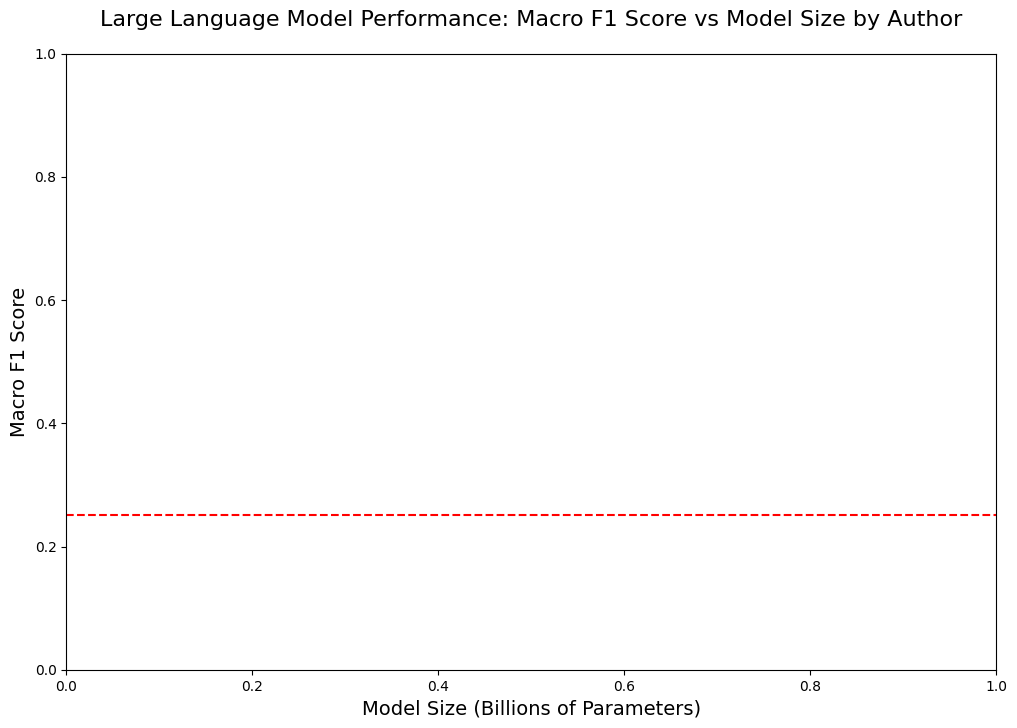

In [79]:
from model_card import ModelCard


evaluate_models([ ModelCard("chatgpt", "4o", "openai",
                  "OpenAI", 0.0017, 0, "./4o_full.csv"),],"brief")

In [83]:
evaluate_models([ ModelCard("chatgpt", "4o", "openai",
                  "OpenAI", 0.0017, 1, "./first.csv"),ModelCard("chatgpt", "4o", "openai",
                  "OpenAI", 0.0017, 2, "./second.csv"), ModelCard("chatgpt", "4o", "openai",
                  "OpenAI", 0.0017, 3, "./third.csv"), ModelCard("chatgpt", "4o", "openai",
                  "OpenAI", 0.0017, 4, "./fourth.csv"), ModelCard("chatgpt", "4o", "openai",
                  "OpenAI", 0.0017, 5, "./fifth.csv"), ModelCard("chatgpt", "4o", "openai",
                  "OpenAI", 0.0017, 6, "./sixth.csv")],"brief")

OpenAI - chatgpt 4o
Size: 1 Billion Parameters
Price: $0.0017/M tokens
Model Metrics Report
Accuracy: 0.45
Macro F1: 0.32
Micro F1: 0.38
Macro Recall: 0.33
Micro Recall: 0.35
Macro Precision: 0.31
Micro Precision: 0.41
Report: None
OpenAI - chatgpt 4o
Size: 2 Billion Parameters
Price: $0.0017/M tokens
Model Metrics Report
Accuracy: 0.34
Macro F1: 0.24
Micro F1: 0.33
Macro Recall: 0.25
Micro Recall: 0.31
Macro Precision: 0.24
Micro Precision: 0.36
Report: None
OpenAI - chatgpt 4o
Size: 3 Billion Parameters
Price: $0.0017/M tokens
Model Metrics Report
Accuracy: 0.34
Macro F1: 0.23
Micro F1: 0.34
Macro Recall: 0.24
Micro Recall: 0.31
Macro Precision: 0.23
Micro Precision: 0.36
Report: None
OpenAI - chatgpt 4o
Size: 4 Billion Parameters
Price: $0.0017/M tokens
Model Metrics Report
Accuracy: 0.36
Macro F1: 0.23
Micro F1: 0.35
Macro Recall: 0.24
Micro Recall: 0.33
Macro Precision: 0.23
Micro Precision: 0.37
Report: None
OpenAI - chatgpt 4o
Size: 5 Billion Parameters
Price: $0.0017/M tokens
M